# Outdated. Now using skimage.feature.hog to obtain features

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import sys
import os
sys.path.insert(0, os.path.join('..','src'))
import numpy as np
import pandas as pd

In [6]:
from utils import kaggle_reader as kr
from analysis import moving_window, hog_classifier

# paths to data folders defined below, please check to make sure they are correct

In [7]:
# homepath is the root path for the project, it should be one level above folders like data/
homepath = os.path.join('..')
# impath is the root folder for the raw images, unzipped. Below assumes those files reside in hompath/data/raw/stage1_train 
# folder and stage1_train/ folder contains sub-folders named with the ImageId, each containing an images/ and masks/ folder.
# This is the structure of the zipped raw data. An unaltered unzipped stage1_train/ folder should have the correct structure
# for the kr.load_all_images to run
impath = os.path.join(homepath, 'data', 'raw', 'stage1_train')

In [10]:
# load all the images into gray scale
imgDF = kr.load_all_raw_images(impath, mode='L')

In [11]:
testimgId = np.random.choice(imgDF.ImageId)
testimg = imgDF[imgDF.ImageId==testimgId].ImageMat.values[0]

We could just use 
features = hog_classifier.extract_hog_features_from_image(testimg)
to get all the features we need for machine learning. But below I show what the middle steps look like.

In [12]:
# first step is to extract the x and y gradient components
gradx, grady = hog_classifier.derivative_mask_1d_centered(testimg)

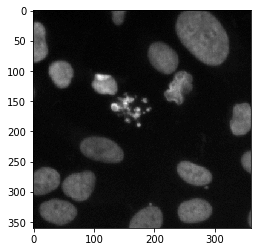

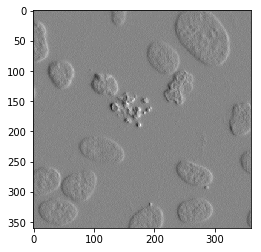

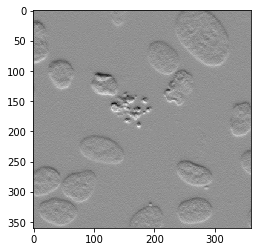

In [14]:
plt.imshow(testimg, cmap='gray')
plt.show()
plt.imshow(gradx, cmap='gray')
plt.show()
plt.imshow(grady, cmap='gray')
plt.show()

In [15]:
# then we extract the orientation and strength of the gradients from the x and y components.
orientation, strength = hog_classifier.find_grad_orientation_strength(gradx, grady)

Text(0.5,1,'strength+image')

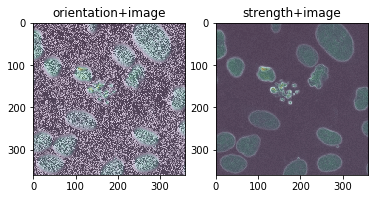

In [16]:
plt.subplot(1,2,1)
plt.imshow(testimg, alpha=0.5)
plt.imshow(orientation, cmap='gray', alpha=0.5)
plt.title('orientation+image')
plt.subplot(1,2,2)
plt.imshow(testimg, alpha=0.5)
plt.imshow(strength, cmap='gray', alpha=0.5)
plt.title('strength+image')

In [17]:
# now we calculate the histogram for cells of the size 8 pixels by 8 pixels, we use a common bin for the histogram
orientation_bins = np.arange(0, np.pi*10/9, np.pi/9)
cell_features = hog_classifier.grad_histogram_by_cell(orientation, strength, orientation_bins, cell_size=8)

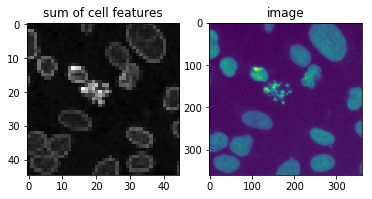

Text(0.5,1,'cell feature plot')

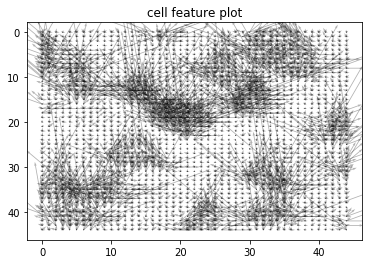

In [18]:
plt.subplot(1,2,1)
plt.imshow(cell_features.sum(axis=2), cmap='gray')
plt.title('sum of cell features')
plt.subplot(1,2,2)
plt.imshow(testimg)
plt.title('image')
plt.show()

ndim = cell_features.shape[2]
for i in range(ndim):
    plt.quiver(cell_features[:,:,i]*np.cos(orientation_bins[i]), 
               cell_features[:,:,i]*np.sin(orientation_bins[i]), alpha=0.3)
plt.gca().invert_yaxis()
plt.title('cell feature plot')

The cell feature plot is messy. For each point, there are 9 vectors representing one of the 9 gradient orientation bins. The length of the vector represents the relative strength of each bin. Here we convert angles to be in the range (0, pi).

In [19]:
# last step, calculate block normalized gradient histogram
block_norm_features = hog_classifier.block_norm_of_cell_histogram(cell_features)

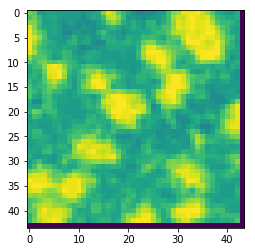

In [20]:
plt.imshow(np.sum(block_norm_features, axis=2))